# <ins>*Leaves of Grass* Analysis</ins>

# Natural Language Processing and Data Exploration

- In this notebook, I engineer features based on poetic form and structure, perform natural language processing techniques, and explore aspects of what makes Whitman Whitman.
- I also create charts and word clouds based on this exploration.

In [1]:
# custom functions for this project
from functions import *

# dataframe packages
import pandas as pd
import numpy as np

# graphing packages
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')
from wordcloud import WordCloud

# statistics packages
import scipy.stats as stats

# text processing
from nltk.corpus import stopwords
from nltk.probability import FreqDist 
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# miscellany
from collections import Counter
import time
import gzip
import pickle

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# increase column width of dataframe
pd.set_option('max_colwidth', 150)

# Preparing the data

[[go back to the top](#Leaves-of-Grass-Analysis)]

- Import data.
- Take a look.

#### 💾 Load DataFrame

In [2]:
with gzip.open('data/whitman_corpus.pkl', 'rb') as hello:
    df = pickle.load(hello)
    
df.shape

(383, 2)

In [3]:
df.head()

,title,poem_string
0,Untitled,"Come, said my soul,\r\n Such verses for my Body let us write, (for we are one,)\r\n That should I after return,\r\n Or, long, long hen..."
1,One’s-Self I Sing,"One’s-self I sing, a simple separate person,\r\n Yet utter the word Democratic, the word En-Masse.\r\n\r\n Of physiology from top to toe I sing,..."
2,As I Ponder’d in Silence,"As I ponder’d in silence,\r\n Returning upon my poems, considering, lingering long,\r\n A Phantom arose before me with distrustful aspect,\r\n ..."
3,In Cabin’d Ships at Sea,"In cabin’d ships at sea,\r\n The boundless blue on every side expanding,\r\n With whistling winds and music of the waves, the large imperious wa..."
4,To Foreign Lands,"I heard that you ask’d for something to prove this puzzle the New World,\r\n And to define America, her athletic Democracy,\r\n Therefore I send..."


In [4]:
# convert strings to list
df['poem_lines'] = df.poem_string.apply(line_creator)

In [5]:
df.head()

,title,poem_string,poem_lines
0,Untitled,"Come, said my soul,\r\n Such verses for my Body let us write, (for we are one,)\r\n That should I after return,\r\n Or, long, long hen...","[Come, said my soul,, Such verses for my Body let us write, (for we are one,), That should I after return,, Or, long, long hence, in other spheres..."
1,One’s-Self I Sing,"One’s-self I sing, a simple separate person,\r\n Yet utter the word Democratic, the word En-Masse.\r\n\r\n Of physiology from top to toe I sing,...","[One’s-self I sing, a simple separate person,, Yet utter the word Democratic, the word En-Masse., Of physiology from top to toe I sing,, Not physi..."
2,As I Ponder’d in Silence,"As I ponder’d in silence,\r\n Returning upon my poems, considering, lingering long,\r\n A Phantom arose before me with distrustful aspect,\r\n ...","[As I ponder’d in silence,, Returning upon my poems, considering, lingering long,, A Phantom arose before me with distrustful aspect,, Terrible in..."
3,In Cabin’d Ships at Sea,"In cabin’d ships at sea,\r\n The boundless blue on every side expanding,\r\n With whistling winds and music of the waves, the large imperious wa...","[In cabin’d ships at sea,, The boundless blue on every side expanding,, With whistling winds and music of the waves, the large imperious waves,, O..."
4,To Foreign Lands,"I heard that you ask’d for something to prove this puzzle the New World,\r\n And to define America, her athletic Democracy,\r\n Therefore I send...","[I heard that you ask’d for something to prove this puzzle the New World,, And to define America, her athletic Democracy,, Therefore I send you my..."


- Based on some earlier EDA, there are several multi-part poems that are skewing some of the data (especially for number of lines per poem) to the right.
- I'll transform these multi-part poems into several single-part poems.
- First, I'll need to find the index numbers of all the multi-part poems.

In [6]:
# instantiate empty list
indices = []

# iterate over index and row
for i, poem in df.iterrows():
    # append index of poems whose first line is '1' to list
    if poem.poem_lines[0] == '1':
        indices.append(i)

# confirm
df[df.index.isin(indices)].head()

,title,poem_string,poem_lines
25,Starting from Paumanok,"1\r\n Starting from fish-shape Paumanok where I was born,\r\n Well-begotten, and rais’d by a perfect mother,\r\n After roaming many lands, love...","[1, Starting from fish-shape Paumanok where I was born,, Well-begotten, and rais’d by a perfect mother,, After roaming many lands, lover of populo..."
26,Song of Myself,"1\r\n I celebrate myself, and sing myself,\r\n And what I assume you shall assume,\r\n For every atom belonging to me as good belongs to you.\r...","[1, I celebrate myself, and sing myself,, And what I assume you shall assume,, For every atom belonging to me as good belongs to you., I loafe and..."
29,I Sing the Body Electric,"1\r\n I sing the body electric,\r\n The armies of those I love engirth me and I engirth them,\r\n They will not let me off till I go with them,...","[1, I sing the body electric,, The armies of those I love engirth me and I engirth them,, They will not let me off till I go with them, respond to..."
82,Salut au Monde!,"1\r\n O take my hand Walt Whitman!\r\n Such gliding wonders! such sights and sounds!\r\n Such join’d unended links, each hook’d to the next,\r\...","[1, O take my hand Walt Whitman!, Such gliding wonders! such sights and sounds!, Such join’d unended links, each hook’d to the next,, Each answeri..."
83,Song of the Open Road,"1\r\n Afoot and light-hearted I take to the open road,\r\n Healthy, free, the world before me,\r\n The long brown path before me leading wherev...","[1, Afoot and light-hearted I take to the open road,, Healthy, free, the world before me,, The long brown path before me leading wherever I choose..."


In [7]:
print(f'Shape of original DataFrame: {df.shape}')

# split multi-part poems into individual poems and append to dataframe
for i in indices:
    df = part_adder(df, i, 'poem_lines')

# drop multi-part versions
df.drop(index=indices, inplace=True)
# reset index
df.reset_index(drop=True, inplace=True)
    
print(f'Shape of transformed DataFrame: {df.shape}')

Shape of original DataFrame: (383, 3)
Shape of transformed DataFrame: (609, 3)


# Step 3: Feature engineering and exploratory data analysis

[[go back to the top](#Leaves-of-Grass-Analysis)]

- Engineer numerical features based on aspects of a poem, including but not limited to line count, line length, usage of end rhymes, and lexical richness.
- Explore these features as a whole and across each movement.
- Create visualizations to better understand the differences and similarities between movements.

### Number of lines

[[go back to the top](#Leaves-of-Grass-Analysis)]

- The number of lines in a poem is often the best measure for the poem's length. I'd like to see the distribution of Whitman's poem lengths.

In [8]:
# check work by first looking at an example
df.loc[0,'poem_lines']

['Come, said my soul,',
 'Such verses for my Body let us write, (for we are one,)',
 'That should I after return,',
 'Or, long, long hence, in other spheres,',
 'There to some group of mates the chants resuming,',
 '(Tallying Earth’s soil, trees, winds, tumultuous waves,)',
 'Ever with pleas’d smile I may keep on,',
 'Ever and ever yet the verses owning—as, first, I here and now',
 'Signing for Soul and Body, set to them my name,',
 'Walt Whitman']

In [9]:
# create number of lines column
df['num_lines'] = df.poem_lines.apply(lambda x: len(x))

# check that it worked
df.loc[0,'num_lines']

10

In [10]:
# descriptive statistics for number of lines as a whole
df.num_lines.describe()

count    609.000000
mean      22.133005
std       29.524082
min        2.000000
25%        9.000000
50%       15.000000
75%       25.000000
max      456.000000
Name: num_lines, dtype: float64

- Poems appear to generally be pretty short, although there may be a few outliers pushing the mean up. I'll try to identify those by looking at any poems above, say, 100 lines.

### Number of lines -- Histogram

[[go back to the top](#Leaves-of-Grass-Analysis)]

- I'll try a histogram of all poems 

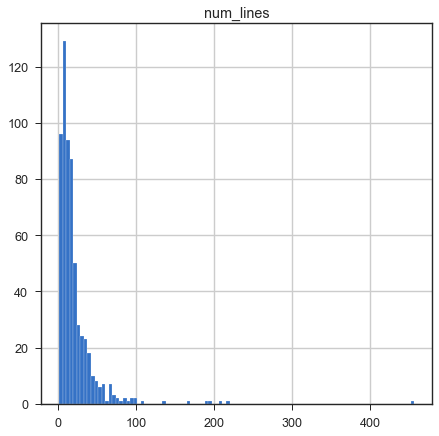

In [11]:
df.hist('num_lines', bins=100, figsize=(7,7));

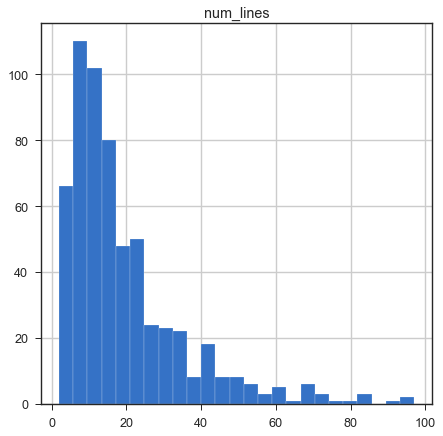

In [12]:
# plot the graph
df[df.num_lines < 100].hist('num_lines', bins=25, figsize=(7,7));

### Number of words

[[go back to the top](#Leaves-of-Grass-Analysis)]

- I'd like to see if the number of words holds any valuable information.
- Also, it will be necessary to calculate for many other features.

In [13]:
# create column using custom word counting function
df['num_words'] = df.poem_lines.apply(word_counter)

In [14]:
# number of words stats as a whole
df.num_words.describe()

count     609.000000
mean      196.756979
std       258.503557
min        14.000000
25%        76.000000
50%       133.000000
75%       229.000000
max      3934.000000
Name: num_words, dtype: float64

### Number of words -- Histogram

[[go back to the top](#Leaves-of-Grass-Analysis)]

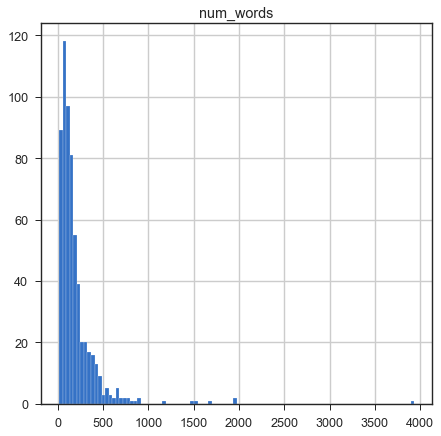

In [15]:
df.hist('num_words', bins=100, figsize=(7,7));

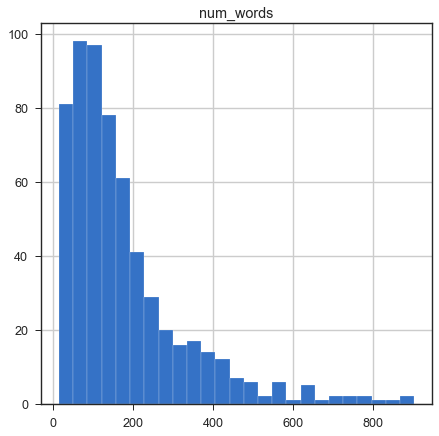

In [16]:
# plot the graph
df[df.num_words < 1000].hist('num_words', bins=25, figsize=(7,7));

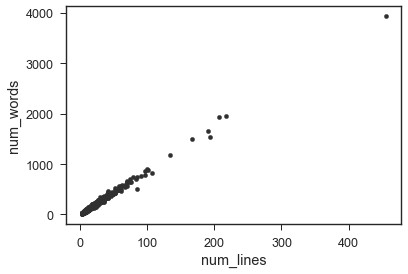

In [17]:
df.plot.scatter('num_lines', 'num_words');

In [18]:
# check correlation
df.num_lines.corr(df.num_words)

0.995594233093748

- Indeed, they are extremely correlated, which most likely signifies a high degree of regularity in Whitman's poetry.
- One might expect a fairly small range of values for my next feature: average line length.

### Average line length

[[go back to the top](#Leaves-of-Grass-Analysis)]

- I can use both of the previously engineered columns to create a measure of the average number of words per line in a poem.

In [19]:
# create column of average number of words per line
df['avg_len_line'] = df.num_words / df.num_lines

In [20]:
# average length of line stats as a whole
df.avg_len_line.describe()

count    609.000000
mean       8.896817
std        1.120671
min        5.400000
25%        8.166667
50%        8.933333
75%        9.562500
max       12.666667
Name: avg_len_line, dtype: float64

- While the range itself is higher than I had expected, it appears that the interquartile range is indeed rather small.

- Removing outliers resulted in all statistically significant tests. In the next notebook, I will have to [deal with outliers](04_modeling.ipynb#Dealing-with-outliers) before modeling.

### Average line length -- Boxplot

[[go back to the top](#Predicting-Poetic-Movements)]

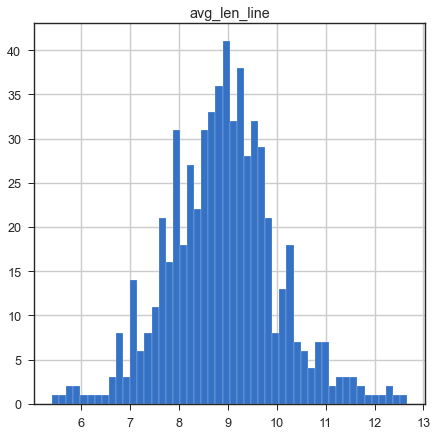

In [21]:
df.hist('avg_len_line', bins=50, figsize=(7,7));

In [22]:
low_bar = df.avg_len_line.mean() - 1.96 * df.avg_len_line.std()
high_bar = df.avg_len_line.mean() + 1.96 * df.avg_len_line.std()

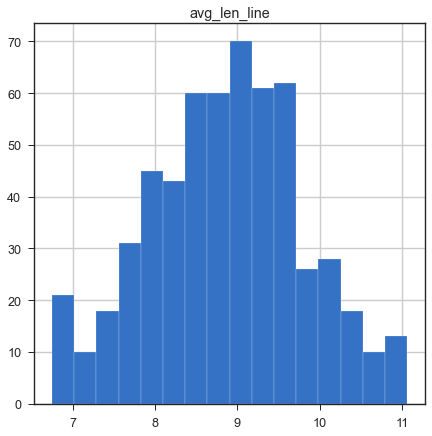

In [23]:
# plot the graph
df[(df.avg_len_line > low_bar) & (df.avg_len_line < high_bar)].hist('avg_len_line', bins=16, figsize=(7,7));

### Sentiment, polarity

[[go back to the top](#Leaves-of-Grass-Analysis)]

- I wonder whether any movements tend to be more positive, negative, or neutral.
- I'll create a new string that includes the titles, using the ```lines_titled``` column.
- I'll use VADER to obtain a polarity score, which I can use as a continuous variable, as well as convert to a categorical variable.

In [24]:
%%time

# instantiate VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# create a column with the compound polarity score, passing in the raw poem
df['sentiment_polarity_score'] = df['poem_string'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

CPU times: user 3.84 s, sys: 26.9 ms, total: 3.87 s
Wall time: 3.91 s


In [25]:
# convert to categorical variable
conditions = [
    df.sentiment_polarity_score >= .05,
    df.sentiment_polarity_score <= -.05
]

choices = [
    'positive',
    'negative'
]

df['sentiment_polarity'] = np.select(conditions, 
                                     choices, 
                                     'neutral')

In [26]:
# polarity score stats as a whole
df.sentiment_polarity_score.describe()

count    609.000000
mean       0.452692
std        0.677987
min       -0.996800
25%        0.000000
50%        0.824200
75%        0.964800
max        0.999800
Name: sentiment_polarity_score, dtype: float64

### Polarity score -- Boxplot

[[go back to the top](#Leaves-of-Grass-Analysis)]

In [27]:
df.sentiment_polarity.value_counts(normalize=True)

positive    0.747126
negative    0.229885
neutral     0.022989
Name: sentiment_polarity, dtype: float64

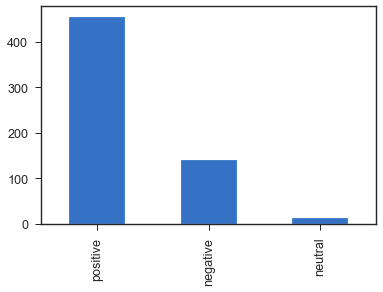

In [28]:
df.sentiment_polarity.value_counts(normalize=False).plot(kind='bar')

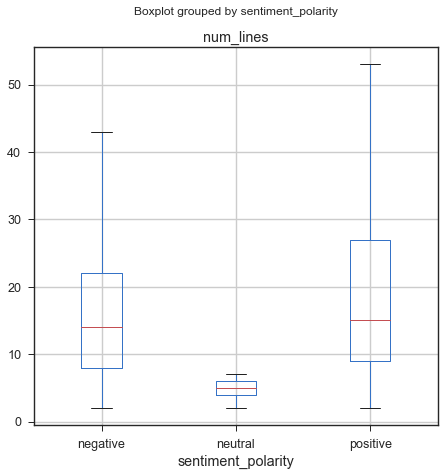

In [33]:
# plot the graph
df.boxplot('num_lines', 'sentiment_polarity', 
           showfliers=False, figsize=(7,7));

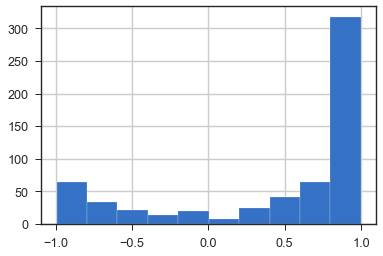

In [30]:
df.sentiment_polarity_score.hist();

In [36]:
df.head()

,title,poem_string,poem_lines,num_lines,num_words,avg_len_line,sentiment_polarity_score,sentiment_polarity
0,Untitled,"Come, said my soul,\r\n Such verses for my Body let us write, (for we are one,)\r\n That should I after return,\r\n Or, long, long hen...","[Come, said my soul,, Such verses for my Body let us write, (for we are one,), That should I after return,, Or, long, long hence, in other spheres...",10,76,7.600000,0.3612,positive
1,One’s-Self I Sing,"One’s-self I sing, a simple separate person,\r\n Yet utter the word Democratic, the word En-Masse.\r\n\r\n Of physiology from top to toe I sing,...","[One’s-self I sing, a simple separate person,, Yet utter the word Democratic, the word En-Masse., Of physiology from top to toe I sing,, Not physi...",9,72,8.000000,0.9576,positive
2,As I Ponder’d in Silence,"As I ponder’d in silence,\r\n Returning upon my poems, considering, lingering long,\r\n A Phantom arose before me with distrustful aspect,\r\n ...","[As I ponder’d in silence,, Returning upon my poems, considering, lingering long,, A Phantom arose before me with distrustful aspect,, Terrible in...",20,163,8.150000,0.4234,positive
3,In Cabin’d Ships at Sea,"In cabin’d ships at sea,\r\n The boundless blue on every side expanding,\r\n With whistling winds and music of the waves, the large imperious wa...","[In cabin’d ships at sea,, The boundless blue on every side expanding,, With whistling winds and music of the waves, the large imperious waves,, O...",29,266,9.172414,0.8856,positive
4,To Foreign Lands,"I heard that you ask’d for something to prove this puzzle the New World,\r\n And to define America, her athletic Democracy,\r\n Therefore I send...","[I heard that you ask’d for something to prove this puzzle the New World,, And to define America, her athletic Democracy,, Therefore I send you my...",3,35,11.666667,0.0000,neutral


In [31]:
please break my code

SyntaxError: invalid syntax (<ipython-input-31-9290159fd349>, line 1)

# Graveyard and whatever the pre-birth equivalent of a graveyard is (because some of this code will eventually be used

- Since some untitled poems use the first line of the poem as the title, and since I'll be using titles in my prediction model, I'll add the title to the poem now.
    - Some titles, however, are simply "Untitled", which I do not want to include.

- 

### Polarity -- Stacked bar chart

[[go back to the top](#Predicting-Poetic-Movements)]

In [ ]:
# proportion of polarity across movement
movement_polarity_dist = df.groupby('movement').\
    sentiment_polarity.value_counts(normalize=True).\
    unstack().sort_values('negative')

# plot the graph
movement_polarity_dist.plot(kind='bar', stacked=True, 
    figsize=(8,7), color=['firebrick', '#e1c400', 'seagreen'], 
    alpha=0.7, fontsize=14)

# prettify the graph
plt.title('Polarity of Poetic Movements', fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Proportion of Polarity', fontsize=22, labelpad=10)

# obtain x-tick-labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() \
                 for label in list(labels)]
labels_pretty[0] = 'Pre-1900'
# plot the labels and legend
plt.xticks(ticks=locs, labels=labels_pretty, rotation=60, fontsize=20)
plt.yticks(fontsize=20);
plt.legend(['Negative', 'Neutral', 'Positive'], facecolor='white', 
           framealpha=1, bbox_to_anchor=(1.01, 1.01), fontsize=18)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/polarity_stackedbar.png', 
#             bbox_inches='tight', transparent=True)

plt.show()

In [ ]:
# numerical representation
movement_polarity_dist

- The breakdown shows a surprisingly similar distribution of polarity across movements.
- Avant-Garde poetry has the most neutral poems, though that is still a small percentage of the poems within that movement.

### Sentiment, subjectivity

[[go back to the top](#Predicting-Poetic-Movements)]

- I wonder whether any movements tend to be more or less objective.
- I'll use TextBlob to obtain a sentiment score.

In [ ]:
%%time

# create a column with the compound polarity score, 
# passing in the raw poem to TextBlob
df['sentiment_subjectivity_score'] = df['string_titled'].\
    apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [ ]:
# subjectivity score stats as a whole
df.sentiment_subjectivity_score.describe()

In [ ]:
# subjectivity score stast by movement
df.groupby('movement').sentiment_subjectivity_score.describe().T

#### Statistical analysis

In [ ]:
# one-way ANOVA
stats.f_oneway(
    df['sentiment_subjectivity_score'][df['movement'] == 'avant_garde'],
    df['sentiment_subjectivity_score'][df['movement'] == 'metropolitan'], 
    df['sentiment_subjectivity_score'][df['movement'] == 'modern'],
    df['sentiment_subjectivity_score'][df['movement'] == 'pre_1900']
)

- At least one statistically significant difference is present.
- I'll now perform two-sided t-tests on all possible combinations within these four categories.

In [ ]:
# list of series on which to perform two-sided t-tests
sentiment_subjectivity_score_list = [
    df['sentiment_subjectivity_score'][df['movement'] == 'avant_garde'],
    df['sentiment_subjectivity_score'][df['movement'] == 'metropolitan'], 
    df['sentiment_subjectivity_score'][df['movement'] == 'modern'],
    df['sentiment_subjectivity_score'][df['movement'] == 'pre_1900']
]

In [ ]:
# test each combination
two_way_tests(sentiment_subjectivity_score_list)

- Avant-Garde and Metropolitan poetries appear to be statistically similar in terms of subjectivity.
- All other combinations show a statistically signficant difference.

### Subjectivity score -- Boxplot

[[go back to the top](#Predicting-Poetic-Movements)]

In [ ]:
# plot the graph
df.boxplot('sentiment_subjectivity_score', 'movement', 
           showfliers=False, figsize=(7,7))

# prettify the graph
plt.title('Subjectivity Score,\nDistribution by Movement', 
          fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Subjectivity Score', fontsize=22, labelpad=10)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() \
                 for label in list(labels)]
labels_pretty[-1] = 'Pre-1900'
# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, 
           rotation=52.5, fontsize=20)
plt.yticks(fontsize=20)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/subjectivity_score_boxplot.png', 
#             bbox_inches='tight', transparent=True)

plt.show()

- Subjectivity seems fairly similar across all movements, all more or less hovering around the midpoint, although again there is a notable difference between Avant-Garde and Pre-1900 poetries.

### Number of end rhymes

[[go back to the top](#Predicting-Poetic-Movements)]

- I would say certain movements definitely rhyme more than others, so let's see if the numbers bear that out.
- Count the number of end rhymes, i.e. lines where the last word rhymes with another line's last word.

In [ ]:
%%time

# run custom function to count the number of end rhymes in a poem
df['num_end_rhymes'] = df.clean_lines.apply(end_rhyme_counter)

In [ ]:
# number of end rhymes stats as a whole
df.num_end_rhymes.describe()

In [ ]:
# number of end rhymes stats by movement
df.groupby('movement').num_end_rhymes.describe().T

#### Statistical analysis

In [ ]:
# one-way ANOVA
stats.f_oneway(
    df['num_end_rhymes'][df['movement'] == 'avant_garde'],
    df['num_end_rhymes'][df['movement'] == 'metropolitan'], 
    df['num_end_rhymes'][df['movement'] == 'modern'],
    df['num_end_rhymes'][df['movement'] == 'pre_1900']
)

- At least one statistically significant difference is present.
- I'll now perform two-sided t-tests on all possible combinations within these four categories.

In [ ]:
# list of series on which to perform two-sided t-tests
num_end_rhymes_list = [
    df['num_end_rhymes'][df['movement'] == 'avant_garde'],
    df['num_end_rhymes'][df['movement'] == 'metropolitan'], 
    df['num_end_rhymes'][df['movement'] == 'modern'],
    df['num_end_rhymes'][df['movement'] == 'pre_1900']
]

In [ ]:
# test each combination
two_way_tests(num_end_rhymes_list)

- All tests other than that between Metropolitan and Modern poetries show statistical signficance.

### Number of end rhymes -- Boxplot

[[go back to the top](#Predicting-Poetic-Movements)]

In [ ]:
# plot the graph
df.boxplot('num_end_rhymes', 'movement', 
           showfliers=False, figsize=(7,7))

# prettify the graph
plt.title('Number of End Rhymes,\nDistribution by Movement', 
          fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Number of End Rhymes', fontsize=22, labelpad=10)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() \
                 for label in list(labels)]
labels_pretty[-1] = 'Pre-1900'
# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty,
           rotation=52.5, fontsize=20)
plt.yticks(fontsize=20)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/num_end_rhymes_boxplot.png', 
#             bbox_inches='tight', transparent=True)

plt.show()

- Unsurprisingly, pre-1900 poetry is far above the rest.
- Similarly unsurprising, avant-garde poetry tends to not have very few end rhymes.

### Ratio of end rhymes

[[go back to the top](#Predicting-Poetic-Movements)]

- Looking at the ratio of end rhymes to the length of the poem may give me a better idea about how prevalent any rhyme scheme actually is.

In [ ]:
# create column of the ratio of end rhymes to the total lines
df['end_rhyme_ratio'] = df.num_end_rhymes / df.num_lines

In [ ]:
# end rhyme ratio stats as a whole
df.end_rhyme_ratio.describe()

In [ ]:
# end rhyme ratio stats by movement
df.groupby('movement').end_rhyme_ratio.describe().T

#### Statistical analysis

In [ ]:
# one-way ANOVA
stats.f_oneway(
    df['end_rhyme_ratio'][df['movement'] == 'avant_garde'],
    df['end_rhyme_ratio'][df['movement'] == 'metropolitan'], 
    df['end_rhyme_ratio'][df['movement'] == 'modern'],
    df['end_rhyme_ratio'][df['movement'] == 'pre_1900']
)

- At least one statistically significant difference is present.
- I'll now perform two-sided t-tests on all possible combinations within these four categories.

In [ ]:
# list of series on which to perform two-sided t-tests
end_rhyme_ratio_list = [
    df['end_rhyme_ratio'][df['movement'] == 'avant_garde'],
    df['end_rhyme_ratio'][df['movement'] == 'metropolitan'], 
    df['end_rhyme_ratio'][df['movement'] == 'modern'],
    df['end_rhyme_ratio'][df['movement'] == 'pre_1900']
]

In [ ]:
# test each combination
two_way_tests(end_rhyme_ratio_list)

- All results here show statistical signficance, so this may be the prefered metric over the number of end rhymes.
- This also connects well with my [earlier analysis](#Number-of-lines) of the number of lines, in delineating between Metropolitan and Modern poetries. 
    - While they shared statistically similar numbers of the number of end rhymes, Modern poetry tends to be shorter (and thus have a higher ratio of rhymes to lines), whereas Metropolitan poetry tends to be longer (and thus have a higher ratio of rhymes to lines).

### Ratio of end rhymes -- Boxplot

[[go back to the top](#Predicting-Poetic-Movements)]

In [ ]:
# plot the graph
df.boxplot('end_rhyme_ratio', 'movement', 
           showfliers=False, figsize=(7,7))

# prettify the graph
plt.title('Ratio of End Rhymes to Line Count,\nDistribution by Movement', 
          fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('End Rhymes to\nLine Count Ratio', fontsize=22, labelpad=10)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() \
                 for label in list(labels)]
labels_pretty[-1] = 'Pre-1900'
# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=20)
plt.yticks(fontsize=20)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/ratio_end_rhymes_boxplot.png', 
#             bbox_inches='tight', transparent=True)

plt.show()

- This plot does seem to show the differences more clearly.
    - Pre-1900 poetry is still in a strong lead, while there is now see some separation between Metropolitan and Modern movements.
    - Modern makes a surprise appearance in second place.
    - Everything else makes sense from a poetry standpoint.
- I'll check if this is too strongly correlated with the number of end rhymes.

In [ ]:
df.plot.scatter('num_end_rhymes', 'end_rhyme_ratio');

In [ ]:
# check correlation
df.num_end_rhymes.corr(df.end_rhyme_ratio)

- They are fairly positively correlated, but there is no definite need to drop either variable.
    
### End rhymes, categorical

[[go back to the top](#Predicting-Poetic-Movements)]

- **NOTE**: Feel free to play around with the metric; first, I tried separating based on 0 end rhymes vs any number of end rhymes.
    - Increasing the 0 value yielded more interesting results (and also weeds out some incidental end rhymes, including those of repeated words).
    - Another tactic is setting a minimum ratio of end rhymes to lines, as seen below.

In [ ]:
# create a yes or no column for whether or not end rhymes occur at least 10% of the time
df['end_rhyme'] = np.where(df.end_rhyme_ratio >= 0.25, 1, 0)

In [ ]:
# proportion as a whole
df.end_rhyme.value_counts(normalize=True)

In [ ]:
# proportion across movements
df.groupby('movement').end_rhyme.value_counts(normalize=True)

### End rhymes -- Stacked bar chart

[[go back to the top](#Predicting-Poetic-Movements)]

In [ ]:
# proportion of end rhymes across movements
movement_rhyme_dist = df.groupby('movement').end_rhyme.\
    value_counts(normalize=True).unstack().sort_values(0)

# plot the graph
movement_rhyme_dist.plot(kind='bar', stacked=True, 
    figsize=(9,7), color=['darkorange', 'royalblue'], 
    alpha=.70, fontsize=14)

# prettify the graph
plt.title('Usage of End Rhymes Across\nPoetic Movements', 
          fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Proportion of Rhyming Poems', 
           fontsize=22, labelpad=10)

# obtain x-tick-labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() \
                 for label in list(labels)]
labels_pretty[0] = 'Pre-1900'
# plot the labels and and legends
plt.xticks(ticks=locs, labels=labels_pretty, 
           rotation=60, fontsize=20)
plt.yticks(fontsize=20);
plt.legend(['No End Rhymes', 'End Rhymes'], facecolor='white', 
           framealpha=1, bbox_to_anchor=(1.01, 1.01), 
           fontsize=18)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/end_rhymes_stackedbar.png', 
#             bbox_inches='tight', transparent=True)

plt.show()

In [ ]:
# numerical representation
movement_rhyme_dist

- Another graph showing similar results more clearly.

### Syllables per word

[[go back to the top](#Predicting-Poetic-Movements)]

- Count the number of total syllables.
- Divide by number of words per poem.

In [ ]:
# divide number of syllables by number of words
df['avg_syllables_word'] = df.lines_titled.apply(
    syllable_counter) / df.num_words

In [ ]:
# average syllables per word stats as a whole
df.avg_syllables_word.describe()

In [ ]:
# average syllables per word stats by movement
df.groupby('movement').avg_syllables_word.describe().T

- The numbers look fairly similar. I'll do some statistical analyses.

#### Statistical analysis

In [ ]:
# one-way ANOVA
stats.f_oneway(
    df['avg_syllables_word'][df['movement'] == 'avant_garde'],
    df['avg_syllables_word'][df['movement'] == 'metropolitan'], 
    df['avg_syllables_word'][df['movement'] == 'modern'],
    df['avg_syllables_word'][df['movement'] == 'pre_1900']
)

- At least one statistically significant difference is present.
- I'll now perform two-sided t-tests on all possible combinations within these four categories.

In [ ]:
# list of series on which to perform two-sided t-tests
avg_syllables_word_list = [
    df['avg_syllables_word'][df['movement'] == 'avant_garde'],
    df['avg_syllables_word'][df['movement'] == 'metropolitan'], 
    df['avg_syllables_word'][df['movement'] == 'modern'],
    df['avg_syllables_word'][df['movement'] == 'pre_1900']
]

In [ ]:
# test each combination
two_way_tests(avg_syllables_word_list)

- This variable appears to be statistically significant across each combination of movements.

### Syllables per word -- Boxplot

[[go back to the top](#Predicting-Poetic-Movements)]

In [ ]:
# plot the graph
df.boxplot('avg_syllables_word', 'movement', 
           showfliers=False, figsize=(7,7))

# prettify the graph
plt.title('Average Number of Syllables per Word,\nDistribution by Movement', 
          fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Number of Syllables', 
           fontsize=22, labelpad=10)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
labels_pretty = [label.get_text().replace('_', '\n').title() \
                 for label in list(labels)]
labels_pretty[-1] = 'Pre-1900'

# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=20)
plt.yticks(fontsize=20)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/avg_syllables_word_boxplot.png', 
#             bbox_inches='tight', transparent=True)

plt.show()

- Surprisingly, in my mind at least, Romantic and Victorian (Pre-1900) are among the simplest vocabularies (words with the least amount of syllables).
- The arguably more intellectual movements (Metropolitan and Avant-Garde) rank among the most complex.

### Lexical richness

[[go back to the top](#Predicting-Poetic-Movements)]

- Count the number of unique words.
- Divide by number of words per poem.

In [ ]:
# divide number of unique words by total words
df['lexical_richness'] = df.lines_titled.apply(
    unique_word_counter) / df.num_words

In [ ]:
# lexical richness as a whole
df.lexical_richness.describe()

In [ ]:
# lexical richness as a whole by movement
df.groupby('movement').lexical_richness.describe().T

- Avant-Garde appears to be the most rich within every quartile, the mean, and the minimum.
- The other three movements have very similar numbers, other than the minimum.

#### Statistical analysis

In [ ]:
# one-way ANOVA
stats.f_oneway(
    df['lexical_richness'][df['movement'] == 'avant_garde'],
    df['lexical_richness'][df['movement'] == 'metropolitan'], 
    df['lexical_richness'][df['movement'] == 'modern'],
    df['lexical_richness'][df['movement'] == 'pre_1900']
)

- At least one statistically significant difference is present.
- I'll now perform two-sided t-tests on all possible combinations within these four categories.

In [ ]:
# list of series on which to perform two-sided t-tests
lexical_richness_list = [
    df['lexical_richness'][df['movement'] == 'avant_garde'],
    df['lexical_richness'][df['movement'] == 'metropolitan'], 
    df['lexical_richness'][df['movement'] == 'modern'],
    df['lexical_richness'][df['movement'] == 'pre_1900']
]

In [ ]:
# test each combination
two_way_tests(lexical_richness_list)

- This variable appears to be statistically significant across every combination of movements other than between Metropolitan and Modern, which makes sense when looking at the descriptive stats across movements.

### Lexical richness -- Boxplot

[[go back to the top](#Predicting-Poetic-Movements)]

In [ ]:
# plot the graph
df.boxplot('lexical_richness', 'movement', 
           showfliers=False, figsize=(7,7))

# prettify the graph
plt.title('Lexical Richness,\nDistribution by Movement', 
          fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Proportion of Unique Words', 
           fontsize=22, labelpad=10)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
labels_pretty = [label.get_text().replace('_', '\n').title() \
                 for label in list(labels)]
labels_pretty[-1] = 'Pre-1900'

# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, 
           rotation=52.5, fontsize=20)
plt.yticks(fontsize=20)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/lexical_richness_boxplot.png', 
#             bbox_inches='tight', transparent=True)

plt.show()

- Avant-Garde poetry is indeed the richest, while Pre-1900 seems to be the most repetitious, though fairly similar to Metropolitan and Modern.
- Pre-1900 also has the most variance, across all quartiles.

# Step 4: Natural language processing

[[go back to the top](#Predicting-Poetic-Movements)]

- Process the text and look at the most frequent words.
- First, prepare a list of stop words. This will include:
    - NLTK stop words.
    - Older English equivalents to those stop words.
    - Poet names (because some may have gotten through in the scraping process), minus any names that may also be used as words.
    - HTML tags that may have gotten through the scraping process.
    - Words of questionable value discovered in the first round of EDA.

In [ ]:
# list of names that may also be used as words
name_keeps = [
    'basil', 'bell', 'bill', 'bottoms', 'brooks', 'brown', 
    'burns', 'butler', 'christian', 'clerk', 'crane', 
    'elephant', 'frank', 'field', 'gallup', 'good', 'guest', 
    'hands', 'hood', 'hooks', 'hunt', 'hunter', 'knight', 
    'lamb', 'lazarus', 'love', 'mare', 'more', 'mark', 
    'moody', 'peacock', 'pound', 'ransom', 'riding', 'savage', 
    'sir', 'white']

# optional
# ['bob', 'dick', 'lee', 'maya', 'sappho', 'sexton', 
#  'smith', 'spender', 'twain', 'walker']

In [ ]:
# instantiate empty set
stop_names = set()

# add first and last names to stop_names
for poet in df.poet:
    name_split = poet.lower().split()
    for name in name_split:
        if name not in name_keeps:
            stop_names.add(name)
            
# convert to list
stop_names = list(stop_names)

# take a look at a sample
stop_names[:10]

In [ ]:
# start with NLTK stop words
stop_words = stopwords.words('english')

# add any html tags that may have snuck through
stop_words.extend(['em', 'div', 'href', 'p'])

# add old-timey stop words
stop_words.extend(old_timers())

# words found in the initial round of EDA that 
# don't provide much meaning
stop_words.extend(['one', 'like', 'would', 'upon', 
                   'yet', 'may', 'could'])

# add the names from above
stop_words.extend(stop_names)

- Create a clean string column.

In [ ]:
%%time

# create column using custom text processing function
# NOTE: includes lemmatization
df['string_cleaned'] = df.string_titled.apply(
    lambda x: clean_text(x, stop_words))

In [ ]:
# check out an example
print(f'BEFORE:\n{df.loc[0, "string_titled"]}')
print('\n' + '-' * 75 + '\n')
print(f'AFTER:\n{df.loc[0, "string_cleaned"]}')

### Total word counts and vocabulary 

[[go back to the top](#Predicting-Poetic-Movements)]

#### Before processing

In [ ]:
# join all pre-processed poems into one string
big_string_pre = ' '.join(df.string_titled)
big_string_pre[:1000]

In [ ]:
# split string into all words in corpus
all_words = big_string_pre.split()

# total words
len(all_words)

In [ ]:
# unique words (vocabulary)
len(list(set(all_words)))

#### After lemmatizing and removing stop words

In [ ]:
# join all processed poems into one string
big_string_proc = ' '.join(df.string_cleaned)
big_string_proc[:1000]

In [ ]:
# split string into processed words in corpus
all_words_proc = big_string_proc.split()

# total processed words
len(all_words_proc)

In [ ]:
# unique processed words (vocabulary)
len(list(set(all_words_proc)))

## Most frequent words

[[go back to the top](#Predicting-Poetic-Movements)]

- Use processed text.

In [ ]:
# create dictionary of word counts
fdist = FreqDist(all_words_proc)

# convert word counts to dataframe
fdist_df = pd.DataFrame(data=fdist.values(), 
                        index=fdist.keys(), 
                        columns=['word_count'])
fdist_df = fdist_df.sort_values('word_count', 
                                ascending=False)

In [ ]:
# look at the top 25 words in the processed corpus
top_25 = fdist_df.iloc[:25,:]
top_25

### Most frequent words overall

[[go back to the top](#Predicting-Poetic-Movements)]

In [ ]:
# create labels and prettify the plot
plt.figure(figsize=(30,10))
plt.title('Top 25 Words', fontsize=36, pad=15)
plt.ylabel('Word Count', fontsize=30, labelpad=15)
plt.xticks(rotation=55, fontsize=28)
plt.yticks(fontsize=28)
plt.ylim(bottom=1000, top=3500)

# plot top 25 words
plt.bar(top_25.index, top_25.word_count, color='purple')

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/top25_words_bar.png', 
#             bbox_inches='tight', transparent=True)

plt.show()

### Most frequent words by movement

[[go back to the top](#Predicting-Poetic-Movements)]

In [ ]:
plt.figure(figsize=(50,25))

movements = list(df.movement.unique())

for i, movement in enumerate(movements):
    # create a series of processed poem strings
    movement_string_series = df[df.movement == movement].\
        string_cleaned
    
    # convert the series to one big string
    movement_big_string = ' '.join(movement_string_series)
    
    # split the big string so I get all words in the movement
    movement_words = movement_big_string.split()
    
    # create dictionary of word counts
    fdist = FreqDist(movement_words)
    
    # convert word counts to dataframe
    fdist_df = pd.DataFrame(data=fdist.values(), 
                            index=fdist.keys(), 
                            columns=['word_count'])
    fdist_df = fdist_df.sort_values('word_count', 
                                    ascending=False)
    
    # look at the top 25 words for the movement
    top_25 = fdist_df.iloc[:25,:]

    # set dimension of plots
    nrows = 2
    ncols = 2

    # list of colors
    colors = ['steelblue', 'olivedrab', 'purple', 'darkorange']
    
    # plot
    plt.subplot(nrows, ncols, i+1)
    plt.title(f'{movement.title().replace("_", "-")} -- Top 25 Words', 
              fontsize=30, pad=15, x=0.5, y=0.9)
    plt.ylabel('Word Count', fontsize=28, labelpad=15)
    plt.xticks(rotation=55, fontsize=25)
    plt.yticks(fontsize=25)
    plt.bar(top_25.index, top_25.word_count, color=colors[i])
              
# # uncomment to save
# plt.savefig('charts/top25_words_movement_bar.png', 
#             bbox_inches='tight', transparent=True)

### Word cloud overall

[[go back to the top](#Predicting-Poetic-Movements)]

In [ ]:
# create a dictionary for easy word cloud creation
word_dict = dict(Counter(all_words_proc))

# create word cloud
wordcloud = WordCloud(colormap='Spectral', 
                      width=1200, 
                      height=600).\
    generate_from_frequencies(word_dict)

# plot word cloud
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# # uncomment to save
# plt.savefig('charts/word_cloud_overall.png', 
#             bbox_inches='tight', transparent=True)

### Word clouds by movement

[[go back to the top](#Predicting-Poetic-Movements)]

In [ ]:
plt.figure(figsize=(50,25))

movements = list(df.movement.unique())

for i, movement in enumerate(movements):
    # create a series of processed poem strings
    movement_string_series = df[df.movement == movement].\
        string_cleaned
    
    # convert the series to one big string
    movement_big_string = ' '.join(movement_string_series)
    
    # split the big string so I get all words in the movement
    movement_words = movement_big_string.split()
    
    # create a dictionary for easy word cloud creation
    movement_word_dict = dict(Counter(movement_words))

    # create word cloud
    movement_wordcloud = WordCloud(colormap='Spectral', 
                                   width=1200, 
                                   height=600).\
        generate_from_frequencies(movement_word_dict)

    nrows = 2
    ncols = 2

    plt.subplot(nrows, ncols, i+1)
    plt.plot()
    plt.imshow(movement_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{movement.title().replace("_", "-")}', 
              fontsize=50, 
              pad=25)
              
# # uncomment to save
# plt.savefig('charts/word_cloud_movement.png', 
#             bbox_inches='tight', transparent=True)

# Preliminary conclusions

[[go back to the top](#Predicting-Poetic-Movements)]

- Pre-1900 poetry is easily recognized.
    - High number of end rhymes, most words per line, simpler words (fewer syllables per word), most positive, and most repetitious.
- Avant-garde is more or less the opposite.
    - Practically no end rhymes, fewest words per line, more complex words (more syllables per word), and richest use of language.
- Metropolitan and Modern poetries are often somewhere in between.
- Poetry is rarely neutral (and generally positive) and fairly equally subjective/objective.
- Frequent vocabulary includes visual and temporal language.

## 💾 Save/Load DataFrame

[[go back to the top](#Predicting-Poetic-Movements)]

In [ ]:
# # uncomment to save
# with gzip.open('data/poetry_movements_df.pkl', 'wb') as goodbye:
#     pickle.dump(df, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# # uncomment to load
# with gzip.open('data/poetry_movements_df.pkl', 'rb') as hello:
#     df = pickle.load(hello)

## Next notebook: [Modeling](04_modeling.ipynb)

[[go back to the top](#Predicting-Poetic-Movements)]

- The next notebook includes classification modeling, a section with reproducible code for this project (including the work within this notebook), conclusions, and acknowledgements.

## Table of contents

1. [Introduction](#Introduction)
2. [The problem domain](#The-problem-domain)
3. [Required libraries](#Required-libraries)
4. [Step 1: Answering some initial questions](#Step-1:-Answering-some-initial-questions)
5. [Step 2: Preparing the data](#Step-2:-Preparing-the-data)

    - [Create movements](#Create-movements)
    
    
6. [Step 3: Feature engineering and exploratory data analysis](#Step-3:-Feature-engineering-and-exploratory-data-analysis)

    - [Number of lines](#Number-of-lines)
        - [Chart](#Number-of-lines----Boxplot)
    - [Number of words](#Number-of-words)
        - [Chart](#Number-of-words----Boxplot)
    - [Average line length](#Average-line-length)
        - [Chart](#Average-line-length----Boxplot)
    - [Sentiment, polarity](#Sentiment,-polarity)
        - [Chart 1](#Polarity-score----Boxplot) | [Chart 2](#Polarity----Stacked-bar-chart)
    - [Sentiment, subjectivity](#Sentiment,-subjectivity)
        - [Chart](#Subjectivity-score----Boxplot)
    - [Number of end rhymes](#Number-of-end-rhymes)
        - [Chart](#Number-of-end-rhymes----Boxplot)
    - [Ratio of end rhymes](#Ratio-of-end-rhymes)
        - [Chart](#Ratio-of-end-rhymes----Boxplot)
    - [End rhymes, categorical](#End-rhymes,-categorical)
        - [Chart](#End-rhymes----Stacked-bar-chart)
    - [Syllables per word](#Syllables-per-word)
        - [Chart](#Syllables-per-word----Boxplot)
    - [Lexical richness](#Lexical-richness)
        - [Chart](#Lexical-richness----Boxplot)
    
    
7. [Step 4: Natural language processing](#Step-4:-Natural-language-processing)

    - [Total word counts and vocabulary](#Total-word-counts-and-vocabulary)
    - [Most frequent words](#Most-frequent-words)
        - [Chart 1](#Most-frequent-words-overall) | [Chart 2](#Most-frequent-words-by-genre) | [Chart3](#Word-cloud-overall) | [Chart 4](#Word-clouds-by-genre)
    

8. [Preliminary conclusions](#Preliminary-conclusions)
9. [Save/Load DataFrame](#💾-Save/Load-DataFrame)
10. [Next notebook: Modeling](#Next-notebook:-Modeling)

## Introduction

[[go back to the top](#Predicting-Poetic-Movements)]

After [scraping](01_webscraping.ipynb) PoetryFoundation.org for genre-labeled poems and [cleaning](02_data_cleaning.ipynb), I will use natural language processing (NLP) techniques to analyze poetic structure across poetic genres and movements. 

Through text processing, exploratory data analysis, and feature engineering, I will look for insights into how poetic structure, word usage, lexical richness, and sentiment relate to the movement of a poem.

I will then create predictive models that classify poems into one of four umbrella movements: *Avant-Garde*, *Metropolitan*, *Modern*, or *Pre-1900*. This will help provide further insight and confirm my findings during EDA. *(To skip to the modeling notebook, click [here](04_modeling.ipynb))*.

The ultimate goal is to create a recommendation system that compares poem similarities and recommends individual poems to users. *(To skip to the recommendation system notebook, click [here](05_recommendation_system.ipynb))*.

## The problem domain

[[go back to the top](#Predicting-Poetic-Movements)]

Within written media, poetry is often regarded as enigmatic, frivolous, or too niche. As a result, poems (even by established poets) are often overlooked by larger publishers and literature-focused websites alike. (The anti-capitalist nature of poetry may play a role here as well). There are services for rating and recommending entire books (including poetry collections, to be fair) like GoodReads, Amazon, or Bookish, but to my knowledge, there aren't any sites or services that recommend poems on an individual level.

With this in mind, I wondered how poem recommendation may even work. One often finds a genre or two that they like and searches that out, but there must be elements of poetry that transcend genre. If there are, machine learning seems like a perfect tool to use to find them. As a poet and writer, I am interested in creating something that will allow me to discover genres and movements that I may have previously ignored. I can do this by using poems I already know and enjoy to find similar poems from genres I may not know as well.

## Required libraries

[[go back to the top](#Predicting-Poetic-Movements)]

This notebook uses several Python packages that come standard with the Anaconda Python distribution. Libraries within this category that I'll be using are:

- **numpy**: Provides a fast numerical array structure and helper functions.
- **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
- **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
- **seaborn**: Advanced statistical plotting library.
- **scikit-learn**: The essential Machine Learning package in Python.
- **scipy**: The essential statistical analysis package in Python.
- **collections**: A package with specialized and higher-performance data structures.
- **warnings**: A helpful package to ignore warnings that unnecessarily clutter the notebook.
- **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.

This notebook also uses some additional packages that you may have to install:

- **nltk**: The essential natural language processing package.
- **textblob**: A supplementary package to enhance the nltk package.
- **vaderSentiment**: A sentiment analysis tool based on human-compiled data.
- **wordcloud**: A library focused on plotting word frequencies.
- **pickle**: Package to save a file as a byte stream.
- **gzip**: Package to compress/unpack files.

Finally, included within the repository, and necessary to run this workbook, is:
- **[functions](functions.py)**: Custom functions that I built for this project.

Required within the functions file, are:
- **itertools**: An package aiding in advanced iteration techniques.
- **regex**: The essential string matching and capturing package.
- **string**: A package with string-specific operations and characters.
- **pronouncing**: A package utilizing the CMU Pronouncing Dictionary that can break language down by syllable, rhyme, and meter.

Run the cell below to import all of the necessary packages.